In [ ]:
# this notebook is to test run the custom stock trading environment

In [1]:
# import helper function for getting stock data
from getstock import get_stock_data_yf_between_with_indicators
# import time library
from datetime import datetime, timedelta
# get stock data with technical indicators
stock_name = 'AAPL'

# period of data to get
period = 365*7
train_period = 365*5
test_period = period - train_period
# start_date in format 'YYYY-MM-DD'
start_date = '2015-01-01'
# calculate end date being x days after start date
start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
end_date_obj = start_date_obj + timedelta(days=period)
end_train_date_obj = start_date_obj + timedelta(days=train_period)
end_date = end_date_obj.strftime('%Y-%m-%d')


interval = '1d'
indicators = ['Volume', 'volume_cmf', 'trend_macd', 'momentum_rsi']

stockdata = get_stock_data_yf_between_with_indicators(stock_name, start_date, end_date, interval, indicators)
stockdata_train = get_stock_data_yf_between_with_indicators(stock_name, start_date, end_train_date_obj, interval, indicators)
stockdata_test = get_stock_data_yf_between_with_indicators(stock_name, end_train_date_obj, end_date, interval, indicators)

# create the gym environment using the stock data
import gym
from TradingEnvClass import StockTradingEnv

init_balance = 20000

import re

[*********************100%***********************]  1 of 1 completed


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


[*********************100%***********************]  1 of 1 completed


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


[*********************100%***********************]  1 of 1 completed


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/media/victoru/B612CEC512CE8A37/stonkdecisiondocker/stonkdecision/src/StockTradingGraph.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.loc[:,'Volume'] = dfvolume


step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
step:  21
step:  22
step:  23
step:  24
step:  25
step:  26
step:  27
step:  28
step:  29
step:  30


ValueError: too many values to unpack (expected 2)

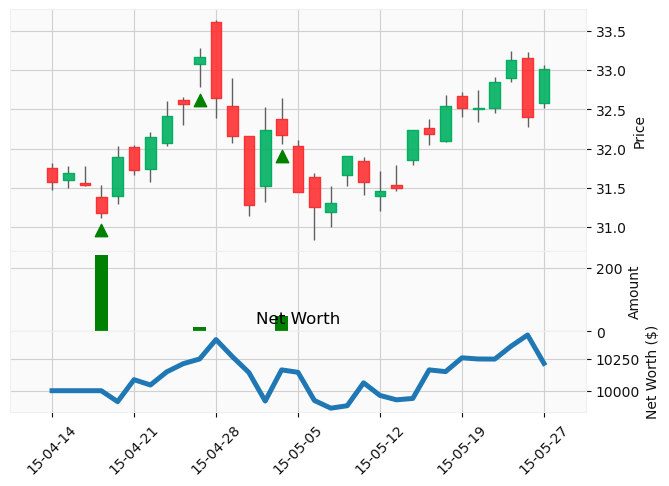

In [4]:
from savefigure import save_figures
teststockdata = stockdata[69:420]
init_balance = 10000
max_step = len(teststockdata)-1

printenv = StockTradingEnv(teststockdata, init_balance, max_step, random = False)

# run the environment with random actions and render the environment\
# this is to check if the environment is working
printenv.reset()
done = False
# create a dictionary to store the frames and the step number
frames = {}
while not done:
    print('step: ', printenv.current_step)
    action = printenv.action_space.sample()
    # print action out to check
    obs, reward, terminated, truncated, info = printenv.step(action)
    done = terminated or truncated
    # check if env.render() returns None
    fig,step = printenv.render(mode='rgb_array')
    if fig is not None:
        frames[step] = fig

printenv.close()

# save the frames as png files
save_figures(frames, 'testenv/')